In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
class AccretionIntegrator:
    # conversion factors to get CGS units into Cholla units
    MP = 1.6726E-24;  # proton mass in grams
    KB = 1.380658e-16; # Boltzmann constant
    LENGTH_UNIT = 3.08567758e21; # kpc in cm
    TINY_NUMBER = 1.0e-20;
    MASS_UNIT = 1.98855e33; # solar mass in grams
    TIME_UNIT = 3.15569e10; # kyr in s
    DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
    VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
    PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);
    
    # solar abundances (percentage of total mass)
    # O, C, N, Si, Mg, Ne, Fe, S
    metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
    metallicity = np.sum(metals)
    
    def __init__(self, T, n, dt):
        self.T = T
        self.n = n
        self.dt = dt
        self._d0_gas, self._d0_metal, self._d0_dust = self.calc_init_density()
        self.d_gas, self.d_metal, self.d_dust = self.calc_init_density()
        self.tau_g = self.calc_tau_g()

    def calc_tau_g(self):
        tau_g_ref = 0.2e-6 * self.TIME_UNIT; # 0.2 Gyr
        d_ref = self.MP * self.LENGTH_UNIT ** 3 / self.MASS_UNIT # 1 H atom per cubic centimer
        T_ref = 20.0;

        tau_g = tau_g_ref * (d_ref/(self._d0_gas+self._d0_dust)) * (T_ref/self.T) ** (1/2);

        return tau_g
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n * self.LENGTH_UNIT ** 3 / self.MASS_UNIT
        d0_metal = self.metallicity * d0_gas
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_metal, d0_dust

    def calc_dd_dt(self):
        tau_g = self.calc_tau_g()
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g)
        
        return dd_dt
    
    def update_densities(self):
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
        self.d_metal -= self.dt * dd_dt
    
    def get_info(self):
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial density: {:.5E} M_sun/kpc^3".format(self._d0_gas))
        print("Growth timescale: {:.5E} kyr".format(self.tau_g))
        print("Time-step: {} yr".format(self.dt))
        print("------------------------------------------")

In [3]:
T0_cells = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

h = 1
n = 1e-2
t_arr = np.arange(0, 1e7, h)
d_dust = np.zeros(shape=(len(T0_cells), len(t_arr)))
time_refine = ["nope"] * len(T0_cells)
trial_integrator = None
d_metal = np.zeros(shape=(len(T0_cells), len(t_arr)))
for j, T in enumerate(T0_cells):
    trial_integrator = AccretionIntegrator(T, n, h)
    trial_integrator.get_info()
    # set initial dust density
    d_dust[j][0] = trial_integrator._d0_dust
    d_metal[j][0] = trial_integrator._d0_metal
    
    for i, t_i in enumerate(t_arr):
        if (i+1) < len(t_arr):
            trial_integrator.update_densities()
            d_dust[j][i+1] = trial_integrator.d_dust
            d_metal[j][i+1] = trial_integrator.d_metal

            """while dd/d_dust_i > 0.01:
            time_refine[j] = "yep!"
            dt_sub = 0.01 * d_dust_i / dd_dt;
            d_dust_i += dd_dt * dt_sub; 

            h -= dt_sub;
            dd_dt = d_dust_accretion(d_dust_i, d_metal, T)

            dd = h * dd_dt;
            """

for j, T in enumerate(T0_cells):
    print(f"Temp: {T} K, Max density: {round(np.amax(d_dust[j]), 2)}, initial density: {round(d_dust[j][0], 2)}")
print("Did time-step refinement get used? ", time_refine)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+05 kyr
Time-step: 1 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+05 kyr
Time-step: 1 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+04 kyr
Time-step: 1 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+04 kyr
Time-step: 1 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.83727E+03 kyr
Time-step: 1 yr
------------------------------------------
Gas temperature: 1.0E+06 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.79459E+03 kyr
Time-step: 1 yr
------------------------------------------
Gas temper

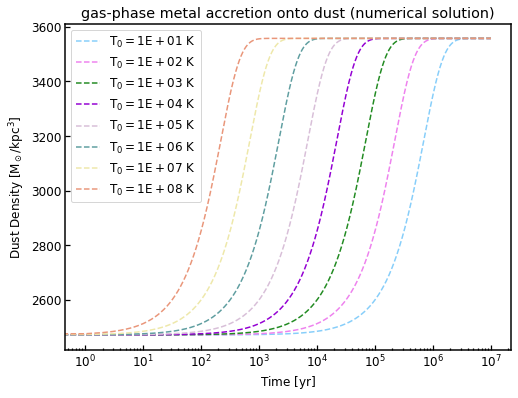

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
#ax.hlines(trial_integrator._d0_metal+trial_integrator._d0_dust, xmin=np.amin(t_arr)-1e10, xmax=np.amax(t_arr)+1e10, color="k", linestyle="-")
for j, T in enumerate(T0_cells):
    ax.semilogx(t_arr, d_dust[j], linestyle="--", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
ax.legend()
ax.set_title("gas-phase metal accretion onto dust (numerical solution)")
plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/accretion_numerical.png", facecolor="white")

Text(0.5, 1.0, 'gas-phase metal accretion onto dust (numerical solution)')

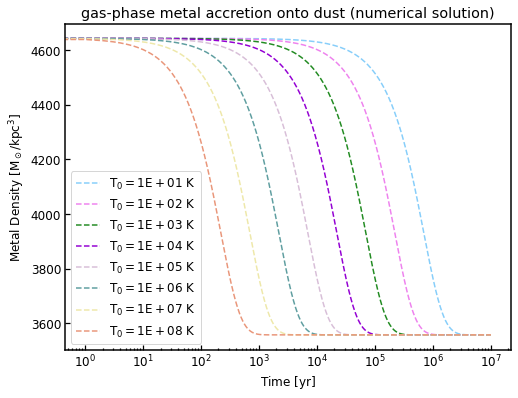

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
#ax.hlines(trial_integrator._d0_metal+trial_integrator._d0_dust, xmin=np.amin(t_arr)-1e10, xmax=np.amax(t_arr)+1e10, color="k", linestyle="-")
for j, T in enumerate(T0_cells):
    ax.semilogx(t_arr, d_metal[j], linestyle="--", color=T_colors[j], label=f"$T_0={T:.0E}~K$")
ax.set_xlabel("Time$~[yr]$")
ax.set_ylabel(r"Metal Density$~[M_\odot/kpc^3]$")
ax.legend()
ax.set_title("gas-phase metal accretion onto dust (numerical solution)")

In [6]:
print(trial_integrator._d0_gas)
print(trial_integrator._d0_dust)
print(trial_integrator._d0_metal)

247119.61128035598
2471.19611280356
4643.37749595789
